In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# Small Molecule R-Group Optimization

>Small molecule R-Group optimization

## R-Group Optimization

Often in drug discovery we want to experiment with changing a specific part of a molecule, while keeping the rest constant. One example of this is optimizing a single R-group on a compound.

One way this is approached is to build a dataset of compounds containing the same core molecule with different R-groups. This however can pose a problem for generative models. Generative models might "lose track" of the desired core strucure during generative screening if it is not strongly enforced.

An efficient solution to this is to only generate the R-group.

This tutorial looks at using the `BlockTemplate` module with a pre-trained R-group generative model to optimize a single R-group. 

## Performance Notes

The workflow in this notebook is more CPU-constrained than GPU-constrained due to the need to evaluate samples on CPU. If you have a multi-core machine, it is recommended that you uncomment and run the `set_global_pool` cells in the notebook. This will trigger the use of multiprocessing, which will result in 2-4x speedups.

This notebook may run slow on Collab due to CPU limitations.

If running on Collab, remember to change the runtime to GPU

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.model_zoo import *
from mrl.combichem import *
from sklearn.metrics import r2_score

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [ ]:
os.makedirs('untracked_files', exist_ok=True)

## Reward

To start we set up our reward function. We use the reward from the <a href="/mrl/tutorials.small_molecule.affinity.html">EGFR Affinity Optimization</a> tutorial. See the affinity optimization tutorial for a full description of the score function and how it was trained.

In brief, the score function predicts the affinity of a compound against the HER1 variant of EGFR.

In [ ]:
reward_model = MLP(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2], outrange=[0,15])

r_ds = Vec_Prediction_Dataset(['C'], [0], partial(failsafe_fp, fp_function=ECFP6))

r_agent = PredictiveAgent(reward_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_state_dict(model_from_url('egfr_affinity_mlp.pt'))

r_agent.model.eval();

freeze(r_agent.model)

reward = Reward(r_agent.predict_data, weight=1.)

# aff_reward = RewardCallback(reward, 'affinity')
aff_reward = RewardCallback(reward, 'affinity', sample_name='samples_fused')

## Base Compound

We will look at optimizing one R-group on `Gefitinib`. Gefitinib is an FDA approved EGFR inhibitor

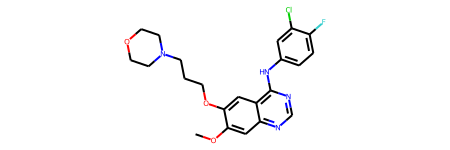

In [ ]:
gefitinib = 'COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1'
to_mol(gefitinib)

In this tutorial, we will optimize the R-group with the morpholine ring. We will build off this scaffold:

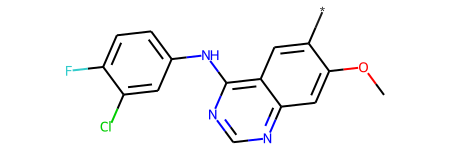

In [ ]:
scaffold = '*c1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC'
to_mol(scaffold)

Gefitinib gets a predicted score of 7.83 from our reward function. For benchmarking our results, we want to see a noticeably higher score

In [ ]:
reward([gefitinib])

tensor(7.8399, device='cuda:0')

## Chemical Space

Next we need to develop our chemical space. This is where we decide what compounds will be allowed and what compounds will be removed.

Getting the right filtering parameters makes a huge difference in compound quality. In practice, finding the right constraints is an interative process. First run a generative screen. Then examine the highest scoring compounds and look for undesirable properties or structural features. Then update the template and iterate.

For R-group optimization, we will make use of the `BlockTemplate` class. Block templates allow us to make a series of nested templates to control different parts of the molecule.

We will create one template for just the R-group, and another template for the full molecule. When we generate an R-group, it will first be checked against the R-group template. Then the R-group will be fused to the scaffold and evaluated using the full molecule template.

This allows us to set seprate constraints on structures in the R-group versus the full molecule.

For the R-group, we specify the group should have 1-2 rings and be between 20-220 g/mol in weight

In [ ]:
r_template = Template(
                    [MolWtFilter(20, 200),
                     RingFilter(1,2)],
                    [],
                    fail_score=-1, log=False
                    )

smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[*]#[Cl,Br,I]',
        '[*]-[Cl,Br,I]-[*]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]',
        '[#6]#[#6]',
        '[#15]',
        '[#16]',
        '[*]=[#17,#9,#35]',
        '[*]=[*]=[*]',
        '[*]-[#6]=[#6H2]',
        '[#7]~[#8]',
        '[#7]~[#7]',
        '[*;R]=[*;!R]']

full_template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     HeteroatomFilter(None, 10),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 520),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 7)
                    ],
                    [], 
                    fail_score=-1., log=False, use_lookup=False)

template = RGroupBlockTemplate(scaffold, r_template, 
                                    full_molecule_template=full_template)

template_cb = TemplateCallback(template, prefilter=True)

## Load Model

We load the `LSTM_LM_Small_Rgroup` model. This is a basic LSTM-based language model trained on R-groups generated from the ZINC library

In [ ]:
agent = LSTM_LM_Small_Rgroup(drop_scale=0.3, opt_kwargs={'lr':5e-5})

## Fine-Tune Model

Our initial model will generate structures that are incompatible with our template. This can slow down training by wasting time generating, evaluating, and filtering unwanted compounds.

To prevent this, we first generate a dataset of valid R-groups and fine-tune the model.

First we sample a large number of R-groups from the model. Then we use our template to filter the R-groups for ones that match our template. Then we fine-tune on the template-conforming subset

In [ ]:
# set_global_pool(min(10, os.cpu_count()))

In [ ]:
%%time
all_smiles = set()
for i in range(200):
    if i%100==0:
        print(i)
    preds, _ = agent.model.sample_no_grad(3000, 45)
    smiles = agent.reconstruct(preds)
    mols = to_mols(smiles)
    smiles = [smiles[i] for i in range(len(smiles)) if mols[i] is not None]
    all_smiles.update(set(smiles))

0
100
200
300
CPU times: user 40min 59s, sys: 1min 39s, total: 42min 38s
Wall time: 4min 42s


In [ ]:
len(all_smiles)

1023323

In [ ]:
# set_global_pool(min(64, os.cpu_count()))

Here we filter the SMILES with the template

In [ ]:
all_smiles = list(all_smiles)
screened = template.recurse_fragments(all_smiles)
screened = [i for i in screened if i[2]]
screened = [i[0] for i in screened]
screened = [i.replace('[2*:1]', '*') for i in screened]
screened = list(set(screened))
len(screened)

99327

Optional: save dataset

In [ ]:
df2 = pd.DataFrame(screened, columns=['smiles'])
df2.to_csv('untracked_files/pretrain_data.csv', index=False)

In [ ]:
# close_global_pool()

Now we fine-tune on our new template-conforming dataset

In [ ]:
# df2 = pd.read_csv('untracked_files/pretrain_data.csv')
# screened = df2.smiles.values
agent.update_dataset_from_inputs(screened)
agent.train_supervised(64, 6, 1e-4)
agent.base_to_model()

Epoch,Train Loss,Valid Loss,Time
0,0.49733,0.51659,00:38
1,0.51667,0.50408,00:39
2,0.41905,0.49675,00:39
3,0.51556,0.50160,00:39
4,0.48622,0.50778,00:38
5,0.44647,0.50791,00:39


Optional: save fine-tuned weights

In [ ]:
# agent.save_weights('untracked_files/finetuned_model.pt')

In [ ]:
agent.load_weights('untracked_files/finetuned_model.pt')

# Reinforcement Learning

Now we enter the reinforcement learning stage

### Loss

We use `PPO` as our policy gradient loss

In [ ]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)

loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

### Samplers

We create the following samplers:
- `sampler1 ModelSampler`: this samples from the main model
- `sampler2 ModelSampler`: this samples from the baseline model
- `sampler3 LogSampler`: this samples high scoring samples from the log
- `sampler4 CombichemSampler`: this sampler runs combichem generation on the top scoring compounds. The combination of generative models with combichem greatly accelerates finding high scoring compounds

In [ ]:
gen_bs = 1500

sampler1 = ModelSampler(agent.vocab, agent.model, 'live', 400, 0., gen_bs)
sampler2 = ModelSampler(agent.vocab, agent.base_model, 'base', 400, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 98, 100)

mutators = [
    ChangeAtom(['6', '7', '8', '9']),
    AppendAtomSingle(['C', 'N', 'O', 'F', 'Cl', 'Br']),
    AppendAtomsDouble(['C', 'N', 'O']),
    DeleteAtom(),
    ChangeBond(),
    InsertAtomSingle(['C', 'N', 'O']),
    InsertAtomDouble(['C', 'N']),
    AddRing(),
    ShuffleNitrogen(10)
]

mc = MutatorCollection(mutators)

crossovers = [FragmentCrossover()]

cbc = CombiChem(mc, crossovers, template=template, rewards=[],
                prune_percentile=70, max_library_size=400, log=True, p_explore=0.2)

sampler4 = CombichemSampler(cbc, 20, 98, 0.2, 1, 'rewards', 'combichem')

samplers = [sampler1, sampler2, sampler3, sampler4]

### Callbacks

Additional callbacks
- `SupervisedCB`: runs supervised training on the top 3% of samples every 400 batches
- `MaxCallback`: prints the max reward for each batch
- `PercentileCallback`: prints the 90th percentile score each batch

In [ ]:
supervised_cb = SupervisedCB(agent, 20, 0.5, 98, 1e-4, 64, epochs=2)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

## Environment and Train

Now we can put together our Environment and run the training process

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[aff_reward], losses=[loss],
                 cbs=cbs)

In [ ]:
set_global_pool(min(10, os.cpu_count()))

In [ ]:
env.fit(128, 45, 350, 20)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,affinity,PPO,rewards_live_p90,rewards_live_max
0,7.582,7.582,1.000,1.000,128,0.000,1.000,7.582,0.087,8.107,8.347
20,7.731,7.731,0.914,1.000,128,0.000,1.000,7.731,0.126,8.074,8.355
40,7.911,7.911,0.773,1.000,128,0.000,1.000,7.911,0.101,8.126,8.304
60,7.890,7.890,0.781,1.000,128,0.000,1.000,7.890,0.105,8.226,8.499
80,7.987,7.987,0.719,1.000,128,0.000,1.000,7.987,0.078,8.211,8.621
100,7.897,7.897,0.766,1.000,128,0.000,1.000,7.897,0.102,8.161,8.487
120,7.947,7.947,0.688,1.000,128,0.000,1.000,7.947,0.102,8.087,8.625
140,7.959,7.959,0.789,1.000,128,0.000,1.000,7.959,0.063,8.289,8.876
160,7.977,7.977,0.789,1.000,128,0.000,1.000,7.977,0.052,8.307,8.737
180,8.017,8.017,0.672,1.000,128,0.000,1.000,8.017,0.115,8.175,8.540


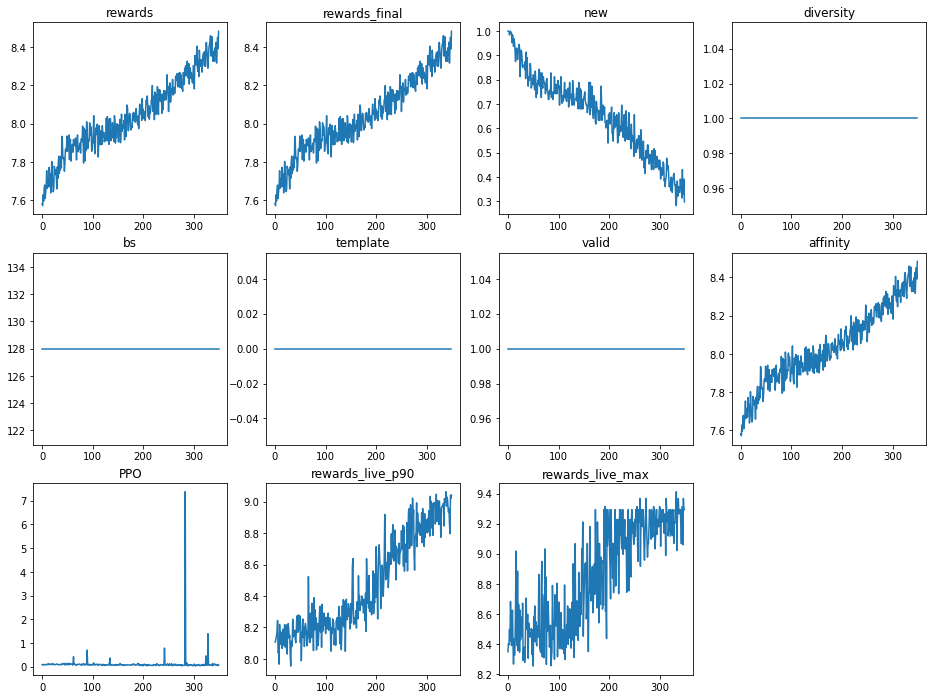

In [ ]:
env.log.plot_metrics()

## Evaluation

Our base compound had a score of 7.84. After 300 batches, we have found ~13,000 compounds with a higher score. We found 7 compounds with a score of 9.25 or higher. Since these scores represent `-log(IC50)`, these new high scoring compounds would have a 25x increase in affinity (assuming you trust our score function 😉)

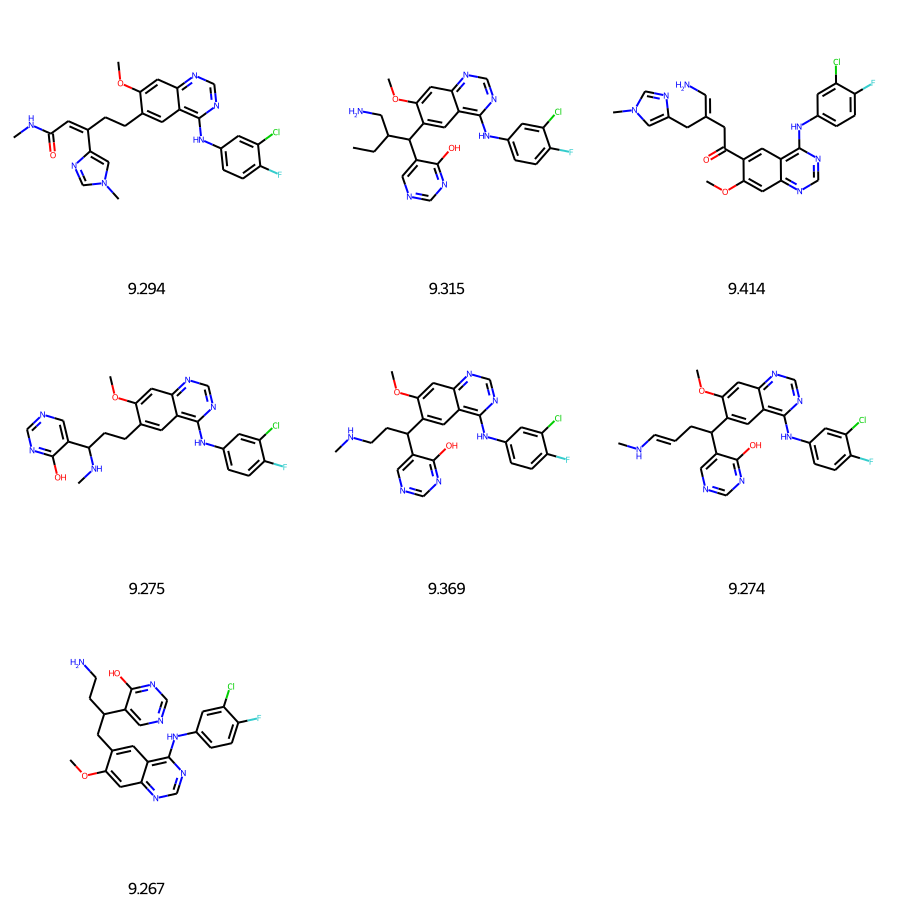

In [ ]:
subset = env.log.df[env.log.df.affinity>9.25]
r_mols = to_mols(subset.samples.values)
mols = to_mols(subset.samples_fused.values)
legends = [f'{subset.affinity.values[i]:.3f}' for i in range(subset.shape[0])]
draw_mols(mols, legends=legends)

Optional: save log dataframe

In [ ]:
# env.log.df.to_csv('untracked_files/gefitinib_rgroup.csv', index=False)